[Solution of the Poisson equation within the domain \[0,1\]](https://github.com/nithinadidela/poisson-eq-FDM/blob/master/Thomas-TDMA.py)

## EXACT SOLUTION

In [ ]:
import numpy as np
import math as m
import scipy.misc as sm
from numba import jit, f8

@jit(f8(f8, f8, f8, f8))
def P0(z, Bi, δ, Gr):
    p1 = -2*Bi*(δ**2)*(z**4)/((1+Bi)*m.factorial(4))
    p2 = 2*(δ**2)*(z**3)/((1+Bi)*m.factorial(3))
    p3 = ((δ**2)*Bi*(Bi+3)-3*Bi*(Bi+1))*(z**2)/(12*((Bi+1)**2))
    p4 = ((3*(Bi+1)-(δ**2)*(Bi+3))/(6*((Bi+1)**2)) - (δ**2)*(4*Bi+15)/(60*(1+Bi)))*z
    return p1 + p2 + p3 + p4 + 1

@jit(f8(f8, f8, f8, f8))
def P11(z, Bi, δ, Gr):
    p1 = Bi*(z**2)/((1+Bi)*m.factorial(2))
    p2 = -z/(1+Bi)
    return p1+p2

@jit(f8(f8, f8, f8, f8))
def T0(z, Bi, δ, Gr):
    t1 = -(Bi*(δ**2)*(z**3))/((1+Bi)*m.factorial(3))
    t2 = ((δ**2)*(z**2))/((1+Bi)*m.factorial(2))
    t3 = ((δ**2)*Bi*(Bi+3)-3*Bi*(Bi+1))*z/(6*((Bi+1)**2))
    t4 = (3*(Bi+1)-(δ**2)*(Bi+3))/(6*((Bi+1)**2)) 
    return t1 + t2 + t3 + t4

def dP0(z, Bi, δ, Gr):
    return sm.derivative(lambda z: P0(z, Bi, δ, Gr), z, dx=0.001)

In [ ]:
import matplotlib.pyplot as plt
from numba import jit, f8

class Parameters:
    def __init__(self, Bi, δ, Gr):
        self.Bi = Bi
        self.δ = δ
        self.Gr = Gr

def PrintExactSolution(exact_solution, parameters):
    l=1.0			     # length of the domain
    n=100			     # number of mesh divisions (for first question)	
    del_z=l/(n-1)		 # mesh size

    z_values = np.zeros(n)
    e_values = np.zeros(n)

    z_values[0] = -1
    e_values[0] = exact_solution(z_values[0], parameters.Bi, parameters.δ, parameters.Gr)

    for i in range(1, len(z_values)):
        z_values[i]=z_values[i-1]+del_z
        e_values[i]=exact_solution(z_values[i], parameters.Bi, parameters.δ, parameters.Gr)

    plt.plot(z_values, e_values, color='blue', markerfacecolor='blue', linestyle='dashed')
    plt.title('Exact solution (Gr={})'.format(parameters.Gr))
    plt.xlabel('Domain')
    plt.ylabel('Exact Solution')
    plt.show()

In [ ]:
PrintExactSolution(P0, Parameters(Bi=2, δ=1.5, Gr=0))

In [ ]:
PrintExactSolution(P11, Parameters(Bi=-3, δ=0, Gr=0))

In [ ]:
PrintExactSolution(T0, Parameters(Bi=-3, δ=0.01, Gr=0))

In [ ]:
PrintExactSolution(dP0, Parameters(Bi=-3, δ=0.01, Gr=0))

## NUMERICAL SOLUTION

In [ ]:
import numba as nb
import math as mt

@nb.jit(f8(nb.f8, nb.f8, nb.f8, nb.f8, nb.f8))
def CalcInitialConditions(z, Bi, δ, Gr, ω):
    C1 = (dP0(z, Bi, δ, Gr) - T0(z, Bi, δ, Gr)) / (δ**2)

    a = 1
    b = -Gr*ω
    c = -1
    D = ((b**2)-4*a*c)/2*a

    k1 = (-b + mt.sqrt(D))/2*a
    k2 = (-b - mt.sqrt(D))/2*a

    λ1 = mt.exp(-k2)/(mt.exp(-k2) - mt.exp(-k1))
    λ2 = -mt.exp(-k1)/(mt.exp(-k2) - mt.exp(-k1))

    return λ1*mt.exp(k1*z) - λ2*mt.exp(k2*z)

In [ ]:
@nb.jit(nb.types.Tuple((nb.f8[:], nb.f8[:]))(nb.f8, nb.f8, nb.f8))
def CalcFirstEquation(δ, Bi, Gr):   
    l=1.0
    n=100
    h=l/(n-1)

    τ = 1e-4
    ε = 1e-5

    z=np.zeros(n)
    α = np.zeros(n+1)
    β = np.zeros(n+1)
    ω = np.zeros(n)

    z[0] = -1
    ω[0] = 0 #CalcInitialConditions(z[0], Bi, δ, Gr, 0.5)

    α[0] = 0
    β[0] = 0

    for i in range(1, n):
        z[i]=i*h + z[0]

        ω_t1 = ω[i-1]
        ω_t2 = 0

        while True:
            C1 = dP0(z[i], Bi, δ, Gr) - T0(z[i], Bi, δ, Gr)

            Ai = ((δ**2)/(h**2) + (Gr*(δ**2)*ω_t1/(2*h)))
            Bi = -2*(δ**2)/(h**2) - 1/τ
            Ci = ((δ**2)/(h**2) - (Gr*(δ**2)*ω_t1/(2*h)))
            Fi =  C1 - ω_t1/τ

            α[i+1] = -Ci/(α[i]*Ai + Bi)
            β[i+1] = (Fi-Ai*β[i])/(α[i]*Ai + Bi)
            ω_t2 = α[i+1]*ω_t1 + β[i+1]

            if abs(ω_t1 - ω_t2) <= ε:
                break

            ω_t1 = ω_t2

        ω[i] = ω_t2
    return z, ω

In [ ]:
δ=1
Bi=-3
Gr=0.03

z, ω = CalcFirstEquation(δ, Bi, Gr)

plt.plot(z, ω, color='blue', markerfacecolor='blue', linestyle='dashed')
plt.title('Numerical solution (Gr={})'.format(Gr))
plt.xlabel('Domain')
plt.ylabel('Numerical Solution')
plt.show()

In [ ]:
CalcInitialConditions(δ=0.01, Bi=2, Gr=0.03, z=-1, ω=0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def FindSolution(z, v_initial, A_func, B_func, C_func, F_func, β0):   
    ε = 1e-5

    α = np.zeros(n+1)
    β = np.zeros(n+1)

    v = np.zeros(n)
    v[0] = v_initial

    α[0] = 0
    β[0] = β0

    for i in range(1, n):
        v_t1 = v[i-1]
        v_t2 = 0

        while True:
            Ai = A_func(i, v_t1)
            Bi = B_func(i, v_t1)
            Ci = C_func(i, v_t1)
            Fi = F_func(i, v_t1)

            α[i+1] = -Ci/(α[i]*Ai + Bi)
            β[i+1] = (Fi-Ai*β[i])/(α[i]*Ai + Bi)
            v_t2 = α[i+1]*v_t1 + β[i+1]

            if abs(v_t1 - v_t2) <= ε:
                break

            v_t1 = v_t2

        v[i] = v_t2

        if i % 10 == 0:
            print('-- {} value: {}'.format(i, v[i]))
    return v

def PrintSolution(z, v, title):
    plt.plot(z, v, color='blue', markerfacecolor='blue', linestyle='dashed')
    plt.title(title)
    plt.xlabel('Domain')
    plt.ylabel('Numerical Solution')
    plt.show()

In [ ]:
def FindBorderT11(z, v_initial, A_func, B_func, C_func, F_func, β0, C):
    ε = 1e-5

    α = np.zeros(n+1)
    β = np.zeros(n+1)

    v = np.zeros(n)
    v[0] = v_initial

    α[0] = 0
    β[0] = β0

    for i in range(1, n):
        v_t1 = v[i-1]
        v_t2 = 0

        while True:
            Ai = A_func(i, v_t1)
            Bi = B_func(i, v_t1)
            Ci = C_func(i, v_t1)
            Fi = F_func(i, v_t1)

            α[i+1] = -Ci/(α[i]*Ai + Bi)
            β[i+1] = (Fi-Ai*β[i])/(α[i]*Ai + Bi)
            v_t2 = β[i+1] / (1 - α[i+1] + C)

            if abs(v_t1 - v_t2) <= ε:
                break

            v_t1 = v_t2

        v[i] = v_t2

        if i % 10 == 0:
            print('-- {} value: {}'.format(i, v[i]))
    return v[-1]

## Generate 'z' values

In [ ]:
import numpy as np

z_left_border = -1.0
z_right_border = 0.0

n=1000
h=(z_right_border - z_left_border)/(n-1)

z = np.zeros(n)
for i in range(0, n):
    z[i]=z_left_border + i*h

print(z)

## Set parameters

In [ ]:
τ = 1e-8

δ=1
Bi=-3
Gr=0.03
Pr=0.7

## Calculate 'ω'

-- 10 value: -2.318447969617757e-09
-- 20 value: -4.401765639464939e-09
-- 30 value: -6.259503435384685e-09
-- 40 value: -7.901110970308914e-09
-- 50 value: -9.33589032224964e-09
-- 60 value: -1.0572996034305516e-08
-- 70 value: -1.1621435114654773e-08
-- 80 value: -1.2490067036555728e-08
-- 90 value: -1.3187603738351173e-08
-- 100 value: -1.3722609623461275e-08
-- 110 value: -1.4103501560393932e-08
-- 120 value: -1.4338548882733882e-08
-- 130 value: -1.4435873389147047e-08
-- 140 value: -1.4403449343382742e-08
-- 150 value: -1.4249103474275276e-08
-- 160 value: -1.3980514975734695e-08
-- 170 value: -1.3605215506758258e-08
-- 180 value: -1.313058919142005e-08
-- 190 value: -1.2563872618879157e-08
-- 200 value: -1.1912154843372573e-08
-- 210 value: -1.1182377384223434e-08
-- 220 value: -1.0381334225833312e-08
-- 230 value: -9.515671817686063e-09
-- 240 value: -8.591889074350017e-09
-- 250 value: -7.616337375470884e-09
-- 260 value: -6.595220565778842e-09
-- 270 value: -5.534594955085797

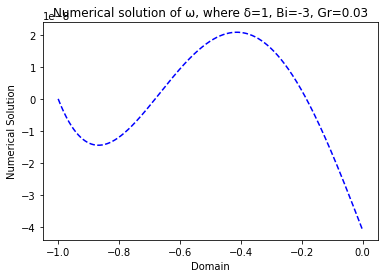

In [24]:
ω_initial = 0

C1_func = lambda i: dP0(z[i], Bi, δ, Gr) - T0(z[i], Bi, δ, Gr)

A_func = lambda i, v_t1: ((δ**2)/(h**2) + (Gr*(δ**2)*v_t1/(2*h)))
B_func = lambda i, v_t1: -2*(δ**2)/(h**2) - 1/τ
C_func = lambda i, v_t1: ((δ**2)/(h**2) - (Gr*(δ**2)*v_t1/(2*h)))
F_func = lambda i, v_t1: C1_func(i) - v_t1/τ

ω = FindSolution(z, ω_initial, A_func, B_func, C_func, F_func, 0)
PrintSolution(z, ω, 'Numerical solution of ω, where δ={}, Bi={}, Gr={}'.format(δ, Bi, Gr))

## Calculate 'u'

-- 10 value: -2.3604156798165576e-08
-- 20 value: -4.398271796007646e-08
-- 30 value: -6.14605871817747e-08
-- 40 value: -7.63318264204765e-08
-- 50 value: -8.886215803371969e-08
-- 60 value: -9.92916959483921e-08
-- 70 value: -1.0783741361911646e-07
-- 80 value: -1.1469537414236145e-07
-- 90 value: -1.2004274544801882e-07
-- 100 value: -1.2403962128115013e-07
-- 110 value: -1.2683066669046686e-07
-- 120 value: -1.2854660493633506e-07
-- 130 value: -1.2930556110116385e-07
-- 140 value: -1.292142762121816e-07
-- 150 value: -1.2836920435569624e-07
-- 160 value: -1.2685750405928641e-07
-- 170 value: -1.2475793413162962e-07
-- 180 value: -1.221416631676602e-07
-- 190 value: -1.1907300103937794e-07
-- 200 value: -1.1561005989077631e-07
-- 210 value: -1.1180535143078113e-07
-- 220 value: -1.0770632666334505e-07
-- 230 value: -1.0335586360219386e-07
-- 240 value: -9.879270798309589e-08
-- 250 value: -9.405187150341702e-08
-- 260 value: -8.916499168218064e-08
-- 270 value: -8.416065703937457e-

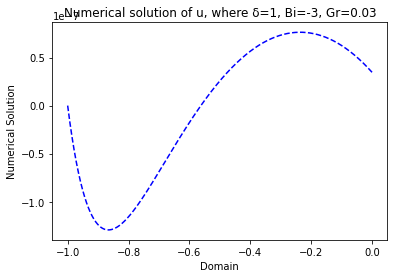

In [25]:
u_initial = 0

C2_func = lambda i: P11(z[i], Bi, δ, Gr)

A_func = lambda i, v_t1: -(1/(h**2) + (Gr*ω[i]/(2*h)))
B_func = lambda i, v_t1: 1/(h**2) + Gr*v_t1 - 1/τ
C_func = lambda i, v_t1: -(1/(h**2) - (Gr*ω[i]/(2*h)))
F_func = lambda i, v_t1: C2_func(i) - v_t1/τ

u = FindSolution(z, u_initial, A_func, B_func, C_func, F_func, 0)
PrintSolution(z, u, 'Numerical solution of u, where δ={}, Bi={}, Gr={}'.format(δ, Bi, Gr))

## Calculate 'T11' (Forward)

-- 10 value: -0.0007040831821760568
-- 20 value: -0.0007040831821760567
-- 30 value: -0.0007040831821760568
-- 40 value: -0.0007040831821760572
-- 50 value: -0.0007040831821760576
-- 60 value: -0.000704083182176058
-- 70 value: -0.000704083182176058
-- 80 value: -0.0007040831821760582
-- 90 value: -0.0007040831821760582
-- 100 value: -0.0007040831821760596
-- 110 value: -0.0007040831821760597
-- 120 value: -0.0007040831821760597
-- 130 value: -0.0007040831821760597
-- 140 value: -0.0007040831821760597
-- 150 value: -0.0007040831821760597
-- 160 value: -0.0007040831821760596
-- 170 value: -0.0007040831821760597
-- 180 value: -0.0007040831821760597
-- 190 value: -0.0007040831821760598
-- 200 value: -0.000704083182176061
-- 210 value: -0.0007040831821760613
-- 220 value: -0.0007040831821760625
-- 230 value: -0.0007040831821760631
-- 240 value: -0.0007040831821760636
-- 250 value: -0.0007040831821760643
-- 260 value: -0.0007040831821760652
-- 270 value: -0.0007040831821760661
-- 280 value:

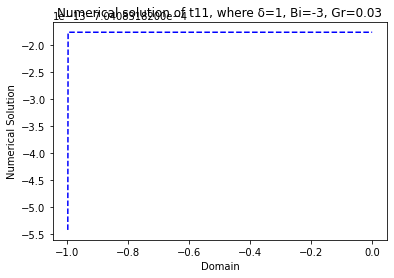

In [21]:
t11_initial = -1

A_func = lambda i, v_t1: 1/(Pr*(h**2)) + (Gr*ω[i]/(2*h))
B_func = lambda i, v_t1: -(2/(Pr*(h**2)) + 2*Gr*u[i] + 1/τ)
C_func = lambda i, v_t1: 1/(Pr*(h**2)) - (Gr*ω[i]/(2*h))
F_func = lambda i, v_t1: -v_t1/τ

t11 = FindSolution(z, t11_initial, A_func, B_func, C_func, F_func, -1)
PrintSolution(z[2:], t11[2:], 'Numerical solution of t11, where δ={}, Bi={}, Gr={}'.format(δ, Bi, Gr))

## Calculate 'T11' (Border)

In [18]:
t11_initial = -1

A_func = lambda i, v_t1: 1/(Pr*(h**2)) + (Gr*ω[i]/(2*h))
B_func = lambda i, v_t1: -(2/(Pr*(h**2)) + 2*Gr*u[i] + 1/τ)
C_func = lambda i, v_t1: 1/(Pr*(h**2)) - (Gr*ω[i]/(2*h))
F_func = lambda i, v_t1: -v_t1/τ

C = Bi*h
t11_border = FindBorderT11(z, t11_initial, A_func, B_func, C_func, F_func, -1, C)
print('\'T11\' border value at z={}: {}'.format(z[-1], t11_border))

-- 10 value: -0.0009189178710295462
-- 20 value: -0.0009469755107241435
-- 30 value: -0.0009758898441125414
-- 40 value: -0.0010056870289219411
-- 50 value: -0.0010363940215625449
-- 60 value: -0.0010680386015140242
-- 70 value: -0.0011006493964565902
-- 80 value: -0.0011342559081693906
-- 90 value: -0.0011688885392196835
-- 100 value: -0.0012045786204669094
-- 110 value: -0.0012413584394065616
-- 120 value: -0.00127926126937949
-- 130 value: -0.0013183213996730608
-- 140 value: -0.0013585741665414035
-- 150 value: -0.0014000559851728136
-- 160 value: -0.0014428043826332244
-- 170 value: -0.001486858031815556
-- 180 value: -0.0015322567864256504
-- 190 value: -0.0015790417170364428
-- 200 value: -0.0016272551482429893
-- 210 value: -0.0016769406969519612
-- 220 value: -0.0017281433118402445
-- 230 value: -0.0017809093140183495
-- 240 value: -0.0018352864389353976
-- 250 value: -0.0018913238795636223
-- 260 value: -0.0019490723309014248
-- 270 value: -0.0020085840358352665
-- 280 value:

## Calculate 'T11' (Backward)

-- 10 value: -0.0007097212707522102
-- 20 value: -0.0007097212707522101
-- 30 value: -0.0007097212707522101
-- 40 value: -0.0007097212707522108
-- 50 value: -0.0007097212707522108
-- 60 value: -0.000709721270752211
-- 70 value: -0.0007097212707522123
-- 80 value: -0.0007097212707522125
-- 90 value: -0.0007097212707522135
-- 100 value: -0.0007097212707522137
-- 110 value: -0.0007097212707522137
-- 120 value: -0.0007097212707522137
-- 130 value: -0.0007097212707522136
-- 140 value: -0.0007097212707522136
-- 150 value: -0.0007097212707522137
-- 160 value: -0.0007097212707522137
-- 170 value: -0.0007097212707522137
-- 180 value: -0.0007097212707522136
-- 190 value: -0.0007097212707522146
-- 200 value: -0.0007097212707522144
-- 210 value: -0.0007097212707522156
-- 220 value: -0.0007097212707522162
-- 230 value: -0.0007097212707522169
-- 240 value: -0.000709721270752218
-- 250 value: -0.0007097212707522189
-- 260 value: -0.0007097212707522194
-- 270 value: -0.0007097212707522198
-- 280 value

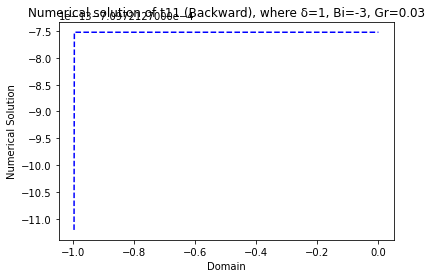

In [20]:
t11_initial = t11_border

A_func = lambda i, v_t1: 1/(Pr*(h**2)) + (Gr*ω[i]/(2*h))
B_func = lambda i, v_t1: -(2/(Pr*(h**2)) + 2*Gr*u[i] + 1/τ)
C_func = lambda i, v_t1: 1/(Pr*(h**2)) - (Gr*ω[i]/(2*h))
F_func = lambda i, v_t1: -v_t1/τ

t11_backward = FindSolution(z[::-1], t11_initial, A_func, B_func, C_func, F_func, -1)
PrintSolution(z[2:], t11_backward[2:], 'Numerical solution of t11 (Backward), where δ={}, Bi={}, Gr={}'.format(δ, Bi, Gr))

## Calculate 'T0'

-- 10 value: 0.0007074674376405364
-- 20 value: 0.000707467339808169
-- 30 value: 0.0007074672419758028
-- 40 value: 0.000707467144143436
-- 50 value: 0.0007074670463110694
-- 60 value: 0.0007074669484787026
-- 70 value: 0.0007074668506463357
-- 80 value: 0.0007074667528139691
-- 90 value: 0.0007074666549816026
-- 100 value: 0.0007074665571492362
-- 110 value: 0.0007074664593168693
-- 120 value: 0.000707466361484503
-- 130 value: 0.000707466263652136
-- 140 value: 0.0007074661658197693
-- 150 value: 0.0007074660679874026
-- 160 value: 0.0007074659701550358
-- 170 value: 0.0007074658723226693
-- 180 value: 0.000707465774490303
-- 190 value: 0.0007074656766579364
-- 200 value: 0.0007074655788255696
-- 210 value: 0.0007074654809932031
-- 220 value: 0.0007074653831608364
-- 230 value: 0.0007074652853284698
-- 240 value: 0.0007074651874961033
-- 250 value: 0.0007074650896637367
-- 260 value: 0.0007074649918313701
-- 270 value: 0.0007074648939990031
-- 280 value: 0.0007074647961666366
-- 290

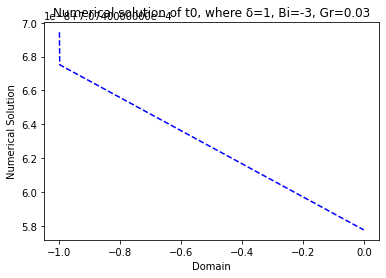

In [22]:
t0_initial = 0.5

A_func = lambda i, v_t1: 1/(Pr*(h**2)) + (Gr*ω[i]/(2*h))
B_func = lambda i, v_t1: -(2/(Pr*(h**2)) + 1/τ)
C_func = lambda i, v_t1: 1/(Pr*(h**2)) - (Gr*ω[i]/(2*h))
F_func = lambda i, v_t1: -v_t1/τ - ((δ**2)*t11[i])/Pr

t0 = FindSolution(z, t0_initial, A_func, B_func, C_func, F_func, 0.5)
PrintSolution(z[1:], t0[1:], 'Numerical solution of t0, where δ={}, Bi={}, Gr={}'.format(δ, Bi, Gr))

## Calculate 'P11'

In [23]:
p11= np.zeros(n)
p11[-1] = 0

for i in range(2, n):
    k1 = t11[-i]
    k2 = t11[-i] # i-th value of 't11' 
    k3 = z[-i] # i-th value of 'z'
    k4 = 0

    p11[-(i+1)] = p11[-i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)